In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import os
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('../')
from dataset import CIFAR10_captioning
from vgg import vgg13_bn

%matplotlib inline

/home/f4_u4/.conda/envs/exp/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libc10_cuda.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
data_dir_path = os.path.join(os.getcwd(), "../", "data")

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616))])

batch_size = 4

# make download true to download data!
trainset = CIFAR10_captioning(root=data_dir_path, train=True, download=False, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
                                          
testset = CIFAR10_captioning(root=data_dir_path, train=False, download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = trainset.classes
print(classes)

('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [12]:
model = vgg13_bn(pretrained=True, device=device).to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

In [13]:
model.eval()
num_correct = 0
total = 0

for images, (labels, target_cls) in testloader:
    images = images.to(device)
    target_cls = target_cls.to(device)
    outputs = model(images)
    _, predictions = torch.max(outputs.data, dim=1)
    num_correct += (predictions == target_cls).sum()
    total += target_cls.size(0)

test_acc = num_correct / total
print("Test Accuracy: %f %%" % (100 * float(test_acc)))

Test Accuracy: 93.529999 %


In [15]:
def fgsm_attack(model, images, labels, criterion, eps):
    images = images.to(device)
    labels = labels.to(device)
    images.requires_grad = True
    outputs = model(images)
    loss = criterion(outputs, labels).to(device)
    loss.backward()
    attack_images = images + eps * images.grad.sign()
    attack_images = torch.clamp(attack_images, 0, 1)
    return attack_images

In [16]:
criterion = torch.nn.CrossEntropyLoss()

In [17]:
for param in model.parameters():
    param.requires_grad = False

model.eval()
num_correct = 0
total = 0

for images, (labels, target_cls) in testloader:
    images = fgsm_attack(model, images, target_cls, criterion, eps=0.02)
    target_cls = target_cls.to(device)
    outputs = model(images)
    _, predictions = torch.max(outputs.data, dim=1)
    num_correct += (predictions == target_cls).sum()
    total += target_cls.size(0)

test_acc = num_correct / total
print("Test Accuracy: %f %%" % (100 * float(test_acc)))

Test Accuracy: 49.239999 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


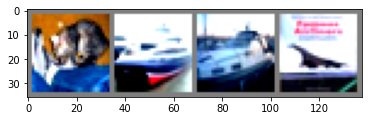

<SOS> An image of a cat <EOS>
<SOS> An image of a ship <EOS>
<SOS> An image of a ship <EOS>
<SOS> An image of a plane <EOS>


In [18]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(testloader)
images, (labels, target_cls) = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
for b in range(batch_size):
    print(' '.join([trainset.vocab[int(i)] for i in labels[b]]))

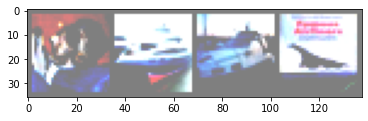

<SOS> An image of a cat <EOS>
<SOS> An image of a ship <EOS>
<SOS> An image of a ship <EOS>
<SOS> An image of a plane <EOS>


In [19]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(testloader)
images, (labels, target_cls) = next(dataiter)

images = fgsm_attack(model, images, target_cls, criterion, eps=0.02)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
for b in range(batch_size):
    print(' '.join([trainset.vocab[int(i)] for i in labels[b]]))